## Machine Learning Final Project - Disaster Tweets 
0612201 YuFeng-Li  
kaggle: https://www.kaggle.com/c/nlp-getting-started  
This topic is to detect which post on tweeter is about **disasters** or **accidents** and which is not.  
  


## Note
在開始訓練前我們需要關心:
1. keyword和location是否重要？
2. text欄位中哪些是停用詞？
3. GloVe的預訓練詞向量是什麼時候訓練的？
4. 文本中哪些詞是預訓練詞向量中沒有的（OOV）？
5. OOV的向量如何決定？ 如何在訓練過程中更新詞向量？

流程:  
data > data cleaning > tokenize > stopwords > glove embedding matrix > LSTM > evaluation & prediction

## Setup environment
This notebook is suggested to run on google colab since it will need to install some third-party packages on your environment.
### Requirements
- Windows/Linux/MacOS (Native Linux)
- Python 3.7+
- ⚠️ **Highly recommend running on google colab**

In [ ]:
# Install additional tools. All of these are used on data cleaning and some pre-processing.
# Those about machine learning will be coded from scratch with only numpy.
# If you have installed on your computer then skip it.

# !sudo apt-get install swig
!pip install cupy pandas sklearn nltk tqdm emoji

import nltk
nltk.download('stopwords')

In [1]:
import os
import re
import cupy as cp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from myutils import Tokenizer, load_weights, pad_sequences

from sproutnet.nn.model import Model
from sproutnet.nn.layers import Embedding, LSTM, Linear, Activation
from sproutnet.nn.activator import sigmoid
from sproutnet.nn.loss import binary_cross_entropy
from sproutnet.nn.metric import BinaryAccuracy
from sproutnet.nn.initializer import GlorotUniform, Orthogonal

In [ ]:
# used on google colab if needed.
# os.chdir('drive/MyDrive/ML/final-project')

In [2]:
# enable your GPU for cupy
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Read data
Read the data and observe it.  
Notice that the most important informations are the **columns**, **labels** and **size**.  

We need to know which columns are important features and the relationship between two or more columns.  

Moreover, check how many unique labels there are, and also the number of each label. In most cases, models are not able to learn from rare occurring labels, which case is called **"class imbalance"**. Thus it's necessary to give the rare classes more weights.  

Last but not least, the bigger the data is, the more noises there are. Some data is less important and may have interference on training. It's recommended to get ride of them if necessary.

In [37]:
# here we read the training data and observe its length, columns, labels
traindf = pd.read_csv('data/train.csv')
labels_count = traindf["target"].value_counts()
# summary
print(f'# of Tweets: {len(traindf)}')
print(f'columns: {traindf.columns.tolist()}')
print(f'labels: {traindf["target"].unique()}')
print(f'counts of each label: {labels_count.to_dict()}')
print(f'score baseline: {(labels_count.max() / labels_count.sum()):.4f}')
print()

traindf.sample(5)

# of Tweets: 7613
columns: ['id', 'keyword', 'location', 'text', 'target']
labels: [1 0]
counts of each label: {0: 4342, 1: 3271}
score baseline: 0.5703



,id,keyword,location,text,target
5149,7343,nuclear%20reactor,Virginia,HamptonRoadsFor.me US Navy Sidelines 3 Newest ...,0
5185,7402,obliterated,NaN,Damnnnn $GMCR got obliterated -26% ;that shoul...,0
7094,10163,violent%20storm,Yuuko-san's shop,Rather violent storm. Possibility of no stream...,1
74,107,accident,North Carolina,I-77 Mile Marker 31 South Mooresville Iredell...,1
310,453,armageddon,NaN,Red Faction: Armageddon (Microsoft Xbox 360 2...,0


In [4]:
testdf = pd.read_csv('data/test.csv')

# summary
print(f'# of Tweets: {len(testdf)}')
print(f'columns: {testdf.columns.tolist()}')
print()

testdf.sample(5)

# of Tweets: 3263
columns: ['id', 'keyword', 'location', 'text']



,id,keyword,location,text
793,2610,crashed,NaN,Rip to whoevers face that crashed in front of ...
2194,7346,obliterate,"Orlando, FL",@TrinityFox_ he would obliterate anyone who ge...
2585,8611,seismic,NaN,My brain feels like it's vibrating inside my s...
3083,10216,volcano,New York,Force Factor VOLCANO 120 Capsule Brand New - ...
3052,10104,typhoon,United States,#abc Obama Declares Disaster for Typhoon-Devas...


Fortunately, the training data seems not large. And the labels are balanced enough (0.57 : 0.43).  
The only thing we need to look out for is that the columns `keyword` and `location` may be a good feature.

<div class="alert alert-block alert-warning">
    <b>💡 If you have done tokenization before, please go <a href="#Read-tokenized-corpus">here</a> to read the pre-tokenized corpus.</b>
</div>

## Ngram Analysis
Let's do a bigram(n=2) analysis on our corpus to see the top common words.

In [ ]:
# 偷懶用一下sklearn的分析工具
from sklearn.feature_extraction.text import CountVectorizer

def top_bigrams(corpus, n_top=10) -> Dict[str, int]:
    vec = CountVectorizer(ngram_range=(2, 2))
    bow = vec.fit_transform(corpus)
    word_counts = bow.sum(axis=0)
    words_freq = [(word, word_counts[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda kv: kv[1], reverse=True)
    
    return dict(words_freq[:n_top])

In [ ]:
print('=== training corpus ===')
for k, v in top_bigrams(traindf['text'].values).items():
    print(f'{k}: {v}')
    
print('\n=== testing corpus ===')
for k, v in top_bigrams(testdf['text'].values).items():
    print(f'{k}: {v}')

Obviousely there are so many url and meaningless words(called stopwords).  
We will need to remove url and those stopwords.

## Data cleaning
- lower casing
- HTML
    - recover html formatted symbols
    - remove html tags
- remove url
- remove emoji
- remove punctuations
- correct spelling
- remove stopwords

### Lower casing

In [ ]:
traindf.loc[:, 'text'] = traindf['text'].str.lower()
testdf.loc[:, 'text'] = testdf['text'].str.lower()

### Recover html formatted symbols
Some words in tweets are html formatted, i.e `%20`, `&amp;`, ...etc.  
We should recover them.

In [ ]:
traindf.loc[:, 'text'] = traindf['text'].str \
                         .replace('%20', ' ').str \
                         .replace('&amp;', '&').str \
                         .replace('\x89û', ' ').str \
                         .replace('\x89', ' ').str \
                         .replace('\\', '')
testdf.loc[:, 'text'] = testdf['text'].str \
                        .replace('%20', ' ').str \
                        .replace('&amp;', '&').str \
                        .replace('\\x89û', ' ').str \
                        .replace('\\x89', ' ').str \
                        .replace('\\', '')

### Remove html tags
Since the tweets are crawled from website, maybe some html tags remain in the data.

In [ ]:
def remove_html_tags(text: str):
    html_tags_filter = re.compile(r'<.+>')
    return html_tags_filter.sub(r'',text)
        
traindf.loc[:, 'text'] = traindf['text'].apply(remove_html_tags)
testdf.loc[:, 'text'] = testdf['text'].apply(remove_html_tags)

### Remove URL

In [ ]:
def remove_url(text: str):
    url_filter = re.compile(r'[a-zA-Z]+://\S+')
    return url_filter.sub(r'', text)
    
traindf.loc[:, 'text'] = traindf['text'].apply(remove_url)
testdf.loc[:, 'text'] = testdf['text'].apply(remove_url)

### Remove emoji
The emoji may be related to sentiment. But is not meaningful to disaster tweets.

In [ ]:
import emoji

def remove_emoji(text: str):
    return emoji.get_emoji_regexp().sub(r'', text)
    
traindf.loc[:, 'text'] = traindf['text'].apply(remove_emoji)
testdf.loc[:, 'text'] = testdf['text'].apply(remove_emoji)

### Remove punctuations
The symbols are meaningless.

In [ ]:
# here we use the python string built-in punctuations.
import string

string.punctuation

In [ ]:
def remove_punctuations(text: str):
    punc_filter = re.compile(f'[{string.punctuation}]')
    return punc_filter.sub(' ', text)
    
traindf.loc[:, 'text'] = traindf['text'].apply(remove_punctuations)
testdf.loc[:, 'text'] = testdf['text'].apply(remove_punctuations)

Notice that we have not correct spellings and removed stopwords yet. It will be done by tokenization.

## Tokenization
Consider the column `text`.  
We need to tokenize the texts into words and use pre-trained word vectors to do embedding.  
The most recommended way to do tokenization is to use the tokenizer corresponding to the pre-trained word vectors model we chose.  
Below are word vectors model we would choose.

### Glove  
Developed by Stanford in 2014.  
The tokenizer would be the tool recommended by Stanford GloVe developers - Stanford EnglishTokenizer, which is under this project [CoreNLP](https://github.com/stanfordnlp/CoreNLP).

### Fasttext
Developed by Facebook in 2016.

### Third-party Tokenizers
- vanilla tokenizer (split by spaces)
- [spaCy tokenizer](https://spacy.io/api/tokenizer)
- [tensorflow tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

In [ ]:
from nltk.corpus import stopwords

# stanza.download()
# nlp = stanza.Pipeline(processors='tokenize')

# it will take about half of an hour to do tokenization.
tokenizer = Tokenizer(tool=str.split)
corpus_tokens = tokenizer.fit([traindf['text'].values, testdf['text'].values], stopwords.words('english'))
train_tokens, test_tokens = corpus_tokens

# save tokenized corpus
# write_corpus(corpus_tokens, 'data/corpus.txt')
tokenizer.save('data/')

### Read tokenized corpus

In [5]:
# read tokenized corpus
tokenizer = Tokenizer(tool=str.split)
corpus_tokens = tokenizer.load('data/')
train_tokens, test_tokens = corpus_tokens

In [6]:
# summary
seqlens_train = np.array([len(tokens) for tokens in train_tokens])
print('=== Tokenized Training Corpus ===')
print(f'# of vocab: {len(tokenizer.word_id)}')
print(f'max sequence length: {seqlens_train.max()}')
print(f'min sequence length: {seqlens_train.min()}')
print(f'avg sequence length: {seqlens_train.mean()}\n')

seqlens_test = np.array([len(tokens) for tokens in test_tokens])
print('=== Tokenized Testing Corpus ===')
print(f'# of vocab: {len(tokenizer.word_id)}')
print(f'max sequence length: {seqlens_test.max()}')
print(f'min sequence length: {seqlens_test.min()}')
print(f'avg sequence length: {seqlens_test.mean()}')

=== Tokenized Training Corpus ===
# of vocab: 15719
max sequence length: 21
min sequence length: 1
avg sequence length: 8.874031262314462

=== Tokenized Testing Corpus ===
# of vocab: 15719
max sequence length: 22
min sequence length: 1
avg sequence length: 8.986515476555317


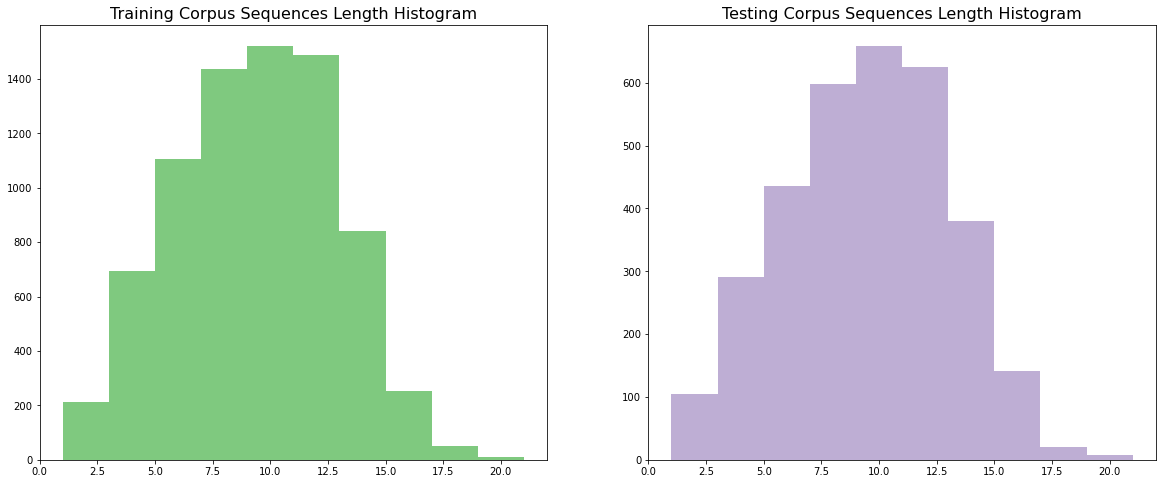

In [7]:
plt.figure(figsize=(20, 8))
palette = iter([plt.cm.Accent(i) for i in range(10)])

plt.subplot(1, 2, 1)
plt.hist(seqlens_train, range=(1, 21), color=next(palette))
plt.title('Training Corpus Sequences Length Histogram', fontsize=16)

plt.subplot(1, 2, 2)
plt.hist(seqlens_test, range=(1, 21), color=next(palette))
plt.title('Testing Corpus Sequences Length Histogram', fontsize=16)

plt.show()

## Embedding Matrix
Now we read the pre-trained file and generate a weight matrix for our vocabulary.

In [8]:
vocab, oov, weights = load_weights('data/glove.twitter.27B.100d.txt', tokenizer.word_id, init_weights='zeros')

In [9]:
weights.shape

(15719, 100)

In [10]:
len(vocab)

11249

In [11]:
oov[:20]

['åáåáåá',
 'forbesasia',
 'strawberrysoryu',
 'dmassa5',
 'nutsandboltssp',
 'marymc21',
 'king5seattle',
 'husnaavhora',
 '÷devastated',
 'radioriffrocks',
 'setting4success',
 'sympathyonlf',
 'deetelecare',
 'ptisalarkhan',
 'keithboykin',
 'mtvsummerstar',
 'sequelae',
 'ceciltownship',
 'crptotech',
 'godslove']

## Training LSTM Neural Network

In [12]:
n_data = len(traindf)
MAX_LEN = 22
null_id = len(tokenizer.word_id) # the word id for pad_sequences value

In [13]:
# append the weight of null_id
emb_weights = np.vstack((weights, np.zeros(shape=weights.shape[-1])))
emb_weights.shape

(15720, 100)

In [22]:
train_X = np.array(pad_sequences(tokenizer.encode(train_tokens), value=null_id, max_length=MAX_LEN))
train_Y = traindf['target'].values.reshape(-1, 1)

test_X = np.array(pad_sequences(tokenizer.encode(test_tokens), value=null_id, max_length=MAX_LEN))

### From Scratch

In [17]:
# from scratch
model = Model(loss=binary_cross_entropy, metric=BinaryAccuracy())
emb_layer = Embedding(input_length=MAX_LEN, weights=emb_weights)
lstm_layer = LSTM(units=32, 
                  weights_initializer=GlorotUniform(fan_in=100, fan_out=32, seed=0),
                  state_weights_initializer=Orthogonal(seed=10))
linear_layer = Linear(units=1, 
                      weights_initializer=GlorotUniform(fan_in=32, fan_out=1, seed=100))
activation_layer = Activation(activator=sigmoid, name='Sigmoid')
model.add_layer(emb_layer, lstm_layer, linear_layer, activation_layer)

model

Layers			Output Shape
____________________________________
Embedding_0:	(22, 100)
LSTM_0:			(32,)
Linear_0:		(1,)
Sigmoid:		(1,)

In [18]:
model.fit(train_X, train_Y, epochs=20, learning_rate=1e-3, batch_size=16)

epoch 19: 100%|========================| 476/476 [00:28<00:00, 16.83it/s, accuracy=0.79, loss=0.454]


In [19]:
# evaluate
model.evaluate(train_X, train_Y)

{'accuracy': 0.7906213056613687, 'loss': 0.4541987340173181}

In [32]:
test_Y_prob = model.predict(test_X)
test_Y = (test_Y_prob > 0.5).astype(int)
testdf['target'] = test_Y.flatten()
testdf.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [33]:
submission = testdf[['id', 'target']]
submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [35]:
submission.to_csv('submissions/submission_2021-12-14.csv', index=False)

### Compare to Keras

## References
- [LSTM: A Search Space Odyssey](https://arxiv.org/abs/1503.04069v2)
- [How LSTM solved vanishing gradients](https://medium.datadriveninvestor.com/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577)
- [Stanford GloVe](https://nlp.stanford.edu/projects/glove/)
- 